In [ ]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import numpy as np
from tqdm import tqdm
from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

In [ ]:
import h5py
from astropy import units as u
from astropy.cosmology import Planck18
from scipy import interpolate

sys.path.append("..")
from dm21cm.evolve import get_z_edges, get_emissivity_bracket
from dm21cm.utils import load_h5_dict
from dm21cm.dh_wrappers import TransferFunctionWrapper
from dm21cm.data_cacher import Cacher
from darkhistory.spec.spectrum import Spectrum
import dm21cm.physics as phys

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


## Calculating shell contribution in one step

In [ ]:
z_edges = get_z_edges(45, 5, 1.001)[1:]

In [ ]:
# let's try to reproduce the second panel
rn_dc = "sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_alldepion_uddn_01atten_ots_adashell40_zf001"
cache_dir = os.environ['P21C_CACHE_DIR'] + f"/{rn_dc}"
with h5py.File(f"{cache_dir}/xraycheck_brightness.h5", 'r') as hf:
    delta = hf['Box_2036'][()]

In [ ]:
rec2 = np.load(f"../outputs/dm21cm/{rn_dc}_2_records_extra.npy", allow_pickle=True).item()

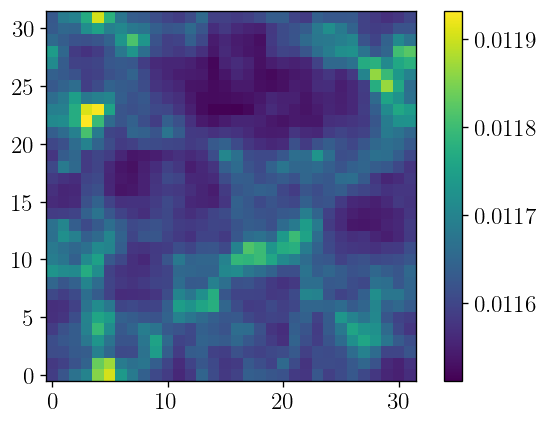

In [ ]:
plt.imshow(np.sum(rec2['dep_box'][-1], axis=-1)[0], origin='lower')
plt.colorbar();

In [ ]:
z = np.sum(rec2['dep_box'][-1], axis=-1)[0]
print(np.std(z)/np.mean(z), np.mean(z))

0.005440204782158525 0.011622862946541196


In [ ]:
x_e_box = rec2['x_e_box'][-1]

In [ ]:
data_dir = os.environ['DM21CM_DATA_DIR'] + f"/tf/zf001/data" # check zf01
sfrd_tables = load_h5_dict(f"{data_dir}/sfrd_tables.h5")
z_range = sfrd_tables['z_range']
delta_range = sfrd_tables['delta_range']
r_range = sfrd_tables['r_range']
cond_sfrd_table = sfrd_tables['cond_sfrd_table']
st_sfrd_table = sfrd_tables['st_sfrd_table']

st_multiplier = 10.
# Takes the redshift as `z`
# Returns the mean ST star formation rate density star formation rate density in [M_Sun / Mpc^3 / s]
ST_SFRD_Interpolator = interpolate.interp1d(z_range, st_sfrd_table * st_multiplier)

In [ ]:
abscs = load_h5_dict(f"{data_dir}/abscissas.h5")
tf_wrapper = TransferFunctionWrapper(
    box_dim = 32,
    abscs = abscs,
    prefix = data_dir,
    enable_elec = False,
    on_device = True,
)

INFO:root:TransferFunctionWrapper: Loaded photon transfer functions.


In [ ]:
spec_cache = pickle.load(open(f"{cache_dir}/spec_cache.p", 'rb'))

In [ ]:
delta_cacher = Cacher(
    data_path="tmp.h5",
    cosmo=Planck18, N=32, dx=2.,
    shell_Rmax=500.,
    Rmax=500.,
)

In [ ]:
i_shell_chosen = [2036, 2035, 2034, 2033, 2032, 2031, 2030, 2029, 2028, 2027, 2026, 2025, 2024, 2023,
                  2021, 2020, 2018, 2016, 2014, 2012, 2009, 2006, 2003, 2000, 1996, 1992, 1987, 1982,
                  1977, 1971, 1964, 1957, 1948, 1939, 1929, 1918, 1906, 1892, 1877, 1861]

In [ ]:
z_current = z_edges[2036]

tf_wrapper.init_step(
    rs = 1 + z_current,
    delta_plus_one_box = jnp.ones((32, 32, 32)),
    x_e_box = x_e_box,
)
dt = phys.dt_step(z_current, np.exp(abscs['dlnz']))

R_arr = []
dep_ion_arr = []

accumulated_N = np.zeros((500,))

for i_z_shell in range(1861, 2037):
    z_shell = z_edges[i_z_shell]
    R2 = phys.conformal_dx_between_z(z_shell, z_current)

    L_X_spec = spec_cache.get_spectrum(z_shell)
    
    cond_sfrd = lambda z, d, r: 1.+d
    emissivity_bracket = get_emissivity_bracket(
        z=z_shell, delta=0., R=R2, dt=dt,
        debug_nodplus1=True, cond_sfrd=cond_sfrd, st_sfrd=ST_SFRD_Interpolator,
    ) # [Msun / Bavg]
    accumulated_N += L_X_spec.N * emissivity_bracket

    if i_z_shell not in i_shell_chosen:
        continue
    
    with h5py.File(f"{cache_dir}/xraycheck_brightness.h5", 'r') as hf:
        delta = hf['Box_'+str(i_z_shell)][()]
    #delta = jnp.fft.irfftn(delta)
    
    delta_smoothed, _ = delta_cacher.smooth_box(delta, 1e-10, R2)

    #L_X_spec = spec_cache.get_spectrum(z_shell)
    
    cond_sfrd = lambda z, d, r: 1.+d
    emissivity_bracket = get_emissivity_bracket(
        z=z_shell, delta=delta_smoothed, R=R2, dt=dt,
        debug_nodplus1=True, cond_sfrd=cond_sfrd, st_sfrd=ST_SFRD_Interpolator,
    ) # [Msun / Bavg]
    emissivity_bracket /= np.mean(emissivity_bracket)

    L_X_spec_inj = Spectrum(abscs['photE'], accumulated_N, spec_type='N', rs=1+z_current)

    dep_ion_mean_before = np.mean(tf_wrapper.dep_box[...,:4])
    tf_wrapper.inject_phot(L_X_spec_inj, inject_type='xray', weight_box=jnp.asarray(emissivity_bracket))
    dep_ion = np.mean(tf_wrapper.dep_box[...,:4]) - dep_ion_mean_before

    accumulated_N *= 0.

    R_arr.append(R2)
    dep_ion_arr.append(dep_ion)

    nBs = 1+delta_smoothed
    print(f"{i_z_shell}, {z_shell:.3f}, {np.std(nBs)/np.mean(nBs):.6f}, {np.mean(nBs):.6f}, {dep_ion:.3e}")

R_arr = np.array(R_arr)
dep_ion_arr = np.array(dep_ion_arr)

# OTS
OTS = False
if OTS:
    with h5py.File(f"{cache_dir}/xraycheck_brightness.h5", 'r') as hf:
        delta = hf['Box_2036'][()]
    z_donor = z_current
    delta = np.fft.irfftn(delta)
    R2 = 0.

    xray_eng_lo = 0.5 * 1000 # [eV]
    xray_eng_hi = 10.0 * 1000 # [eV]
    xray_i_lo = np.searchsorted(abscs['photE'], xray_eng_lo)
    xray_i_hi = np.searchsorted(abscs['photE'], xray_eng_hi)
    L_X_numerical_factor = 1e60 # make float happy

    L_X_spec_prefac = 1e40 / np.log(4) * u.erg * u.s**-1 * u.M_sun**-1 * u.yr * u.keV**-1 # value in [erg yr / s Msun keV]
    L_X_spec_prefac /= L_X_numerical_factor
    # L_X (E * dN/dE) \propto E^-1
    L_X_dNdE = L_X_spec_prefac.to('1/Msun').value * (abscs['photE']/1000.)**-1 / abscs['photE'] # [1/Msun] * [1/eV] = [1/Msun eV]
    L_X_dNdE[:xray_i_lo] *= 0.
    L_X_dNdE[xray_i_hi:] *= 0.
    L_X_spec = Spectrum(abscs['photE'], L_X_dNdE, spec_type='dNdE', rs=1+z_current) # [1 / Msun eV]
    L_X_spec.switch_spec_type('N') # [1 / Msun]

    cond_sfrd = lambda z, d, r: 1.+d
    emissivity_bracket = get_emissivity_bracket(
        z=z_donor, delta=delta, R=R2, dt=dt,
        debug_nodplus1=True, cond_sfrd=cond_sfrd, st_sfrd=ST_SFRD_Interpolator,
    ) # [Msun / Bavg]

    tf_wrapper.inject_phot(L_X_spec, inject_type='xray', weight_box=jnp.asarray(emissivity_bracket))

1861, 6.154, 0.000000, 1.000000, 3.127e-06
1877, 6.041, 0.000061, 1.000000, 5.930e-05
1892, 5.936, 0.000103, 1.000000, 6.718e-05
1906, 5.839, 0.000120, 1.000000, 7.330e-05
1918, 5.758, 0.000082, 1.000000, 7.903e-05
1929, 5.684, 0.000144, 1.000000, 7.712e-05
1939, 5.617, 0.000066, 1.000000, 9.331e-05
1948, 5.558, 0.000199, 1.000000, 8.849e-05
1957, 5.499, 0.000346, 1.000000, 1.095e-04
1964, 5.454, 0.000419, 1.000000, 9.578e-05
1971, 5.409, 0.000389, 1.000000, 1.073e-04
1977, 5.371, 0.000554, 1.000000, 1.118e-04
1982, 5.339, 0.000392, 1.000000, 9.634e-05
1987, 5.307, 0.000973, 1.000000, 1.197e-04
1992, 5.276, 0.000770, 1.000000, 1.287e-04
1996, 5.251, 0.001295, 1.000000, 1.099e-04
2000, 5.226, 0.001457, 1.000000, 1.241e-04
2003, 5.207, 0.001324, 1.000000, 9.438e-05
2006, 5.189, 0.002332, 1.000000, 9.557e-05
2009, 5.170, 0.002779, 1.000000, 9.691e-05
2012, 5.152, 0.001615, 1.000000, 9.825e-05
2014, 5.140, 0.004259, 1.000000, 6.625e-05
2016, 5.127, 0.005807, 1.000000, 6.685e-05
2018, 5.115

0.015062688330166257 0.011056575275230462


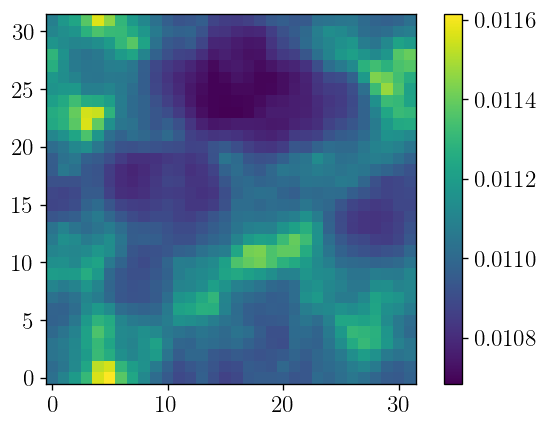

In [ ]:
dep_ion_box = np.sum(tf_wrapper.dep_box[...,:4], axis=-1)
plt.imshow(dep_ion_box[0], origin='lower', cmap='viridis')
plt.colorbar()
print(np.std(dep_ion_box)/np.mean(dep_ion_box), np.mean(dep_ion_box))

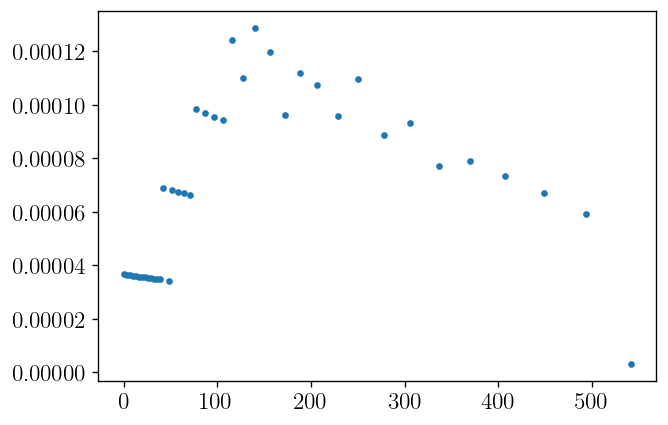

In [ ]:
plt.plot(R_arr, dep_ion_arr, '.')

/tmp/ipykernel_349766/3144214641.py:1: RuntimeWarning: divide by zero encountered in log10
  dlogR = np.diff(-np.log10(R_arr))


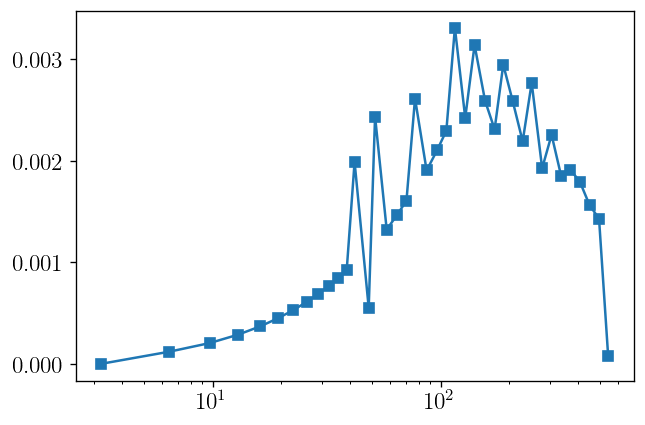

In [ ]:
dlogR = np.diff(-np.log10(R_arr))
plt.plot(R_arr[:-1], dep_ion_arr[:-1]/dlogR, '-s')
plt.xscale('log')

## Doing the same but with more similar code from main

In [ ]:
from dm21cm.evolve import geom_inds, custom_SFRD, debug_get_21totf_interp
from dm21cm.spectrum import AttenuatedSpectrum
import py21cmfast as p21c

In [ ]:
z_edges = get_z_edges(45, 5, 1.001)[1:]

delta_cacher_recon = Cacher(
    data_path="tmp/xraycheck_brightness.h5",
    cosmo=Planck18, N=32, dx=2.,
    shell_Rmax=500.,
    Rmax=500.,
)
delta_cacher_recon.brightness_cache.z_s = z_edges[:-1]
delta_cacher_recon.spectrum_cache = pickle.load(open(f"{cache_dir}/spec_cache.p", 'rb'))

In [ ]:
phys.conformal_dx_between_z(z_edges[1900], 5)

428.1735231404039

In [ ]:
## let's try the dicke factor
# Box layout and fourier operations
N = 32
dx = 2
cosmo = Planck18

k = np.fft.fftfreq(N, d = dx)
kReal = np.fft.rfftfreq(N, d = dx)
kMag = 2*np.pi*np.sqrt(k[:, None, None]**2 + k[None, :, None]**2 + kReal[None, None, :]**2)


def dicke(z):
    
    omegaM_z = cosmo.Om0*pow(1+z,3) / (cosmo.Ode0+cosmo.Om0*pow(1+z,3) + p21c.global_params.OMr*pow(1+z,4) )
    dick_z = 2.5*omegaM_z / ( 1.0/70.0 + omegaM_z*(209-omegaM_z)/140.0 + pow(omegaM_z, 4.0/7.0) )
    dick_0 = 2.5*cosmo.Om0 / ( 1.0/70.0 + cosmo.Om0*(209-cosmo.Om0)/140.0 + pow(cosmo.Om0, 4.0/7.0) )
    
    return dick_z / (dick_0 * (1.0+z))

def smooth_perturbed_field(delta_dep, z_dep, R, zp):
    z = z_dep
    
    W = 3*(np.sin(kMag*R) - kMag*R * np.cos(kMag*R)) / (kMag*R)**3
    W[0, 0, 0] = 1
    
    
    # Now I have the smoothed field evaluated at z, the redshift of the perturbed field
    smoothed_field = np.fft.irfftn(np.fft.rfftn(delta_dep)*W)  
    
    # Now I divide by the growth factor at z to get the smoothed field scaled to z = 0
    smoothed_field /= dicke(z)
    
    # Now I multiply by the growth factor at the target zp
    smoothed_field *= dicke(zp)
    
    return smoothed_field

In [ ]:
deltaplusone_box_s = []
dep_ion_box_s = []
z_s = []
R_arr = []
dep_ion_arr = []

#------

use_dicke_factor = True

#------

i_z = 2036
z_current = z_edges[i_z]
i_xraycheck_shell_start = 1900 # CHECK LATER!!!
adaptive_shell = 40
debug_flags = ['xc-01attenuation', 'xc-custom-SFRD', 'xc-ots']
debug_nodplus1 = True
EPSILON = 1e-6
#debug_use_21_totinj = "../scripts/sf_xdecayx10_nodplus1_noxesink_nopop2_alldepion_zf001.out"
debug_use_21_totinj = None
if debug_use_21_totinj is not None:
    ref_interp = debug_get_21totf_interp(debug_use_21_totinj)
xray_eng_lo = 0.5 * 1000 # [eV]
xray_eng_hi = 10.0 * 1000 # [eV]
xray_i_lo = np.searchsorted(abscs['photE'], xray_eng_lo)
xray_i_hi = np.searchsorted(abscs['photE'], xray_eng_hi)
L_X_numerical_factor = 1e60 # make float happy

tf_wrapper.init_step(
    rs = 1 + z_current,
    delta_plus_one_box = jnp.ones((32, 32, 32)),
    x_e_box = x_e_box,
)

i_max = i_z - i_xraycheck_shell_start
inds_increasing = geom_inds(i_max=i_max, i_transition=10, n_goal=adaptive_shell)
inds_shell = i_z - inds_increasing
print('adaptive shell:', inds_shell, flush=True)

accumulated_shell_N = np.zeros_like(abscs['photE']) # [ph / Bavg]

for i_z_shell in range(i_xraycheck_shell_start, i_z):

    z_shell = z_edges[i_z_shell]
    R2 = phys.conformal_dx_between_z(z_shell, z_current)

    #--- for all shells ---
    shell_N = np.array(delta_cacher_recon.spectrum_cache.get_spectrum(z_shell).N) # [ph / Msun]
    if 'xc-custom-SFRD' in debug_flags:
        cond_sfrd = custom_SFRD
    else:
        raise NotImplementedError
    emissivity_bracket = get_emissivity_bracket(
        z=z_shell, delta=0., R=phys.conformal_dx_between_z(z_shell, z_current), dt=dt,
        debug_nodplus1=debug_nodplus1, cond_sfrd=cond_sfrd, st_sfrd=ST_SFRD_Interpolator,
    ) # [Msun / Bavg] # get average

    accumulated_shell_N += shell_N * emissivity_bracket # [ph / Bavg]
    if i_z_shell not in inds_shell:
        continue

    #--- now, the chosen ones ---
    delta, L_X_spec, xraycheck_is_box_average, z_donor, R2 = delta_cacher_recon.get_annulus_data(
        z_current, z_edges[i_z_shell], z_edges[i_z_shell+1]
    )

    if use_dicke_factor:
        with h5py.File(f"{cache_dir}/xraycheck_brightness.h5", 'r') as hf:
            delta = np.fft.irfftn(hf['Box_2036'][()])
        delta = smooth_perturbed_field(delta, z_current, R2, z_shell)

    deltaplusone_box_s.append(1+delta)
    z_s.append(z_shell)
    R_arr.append(R2)
    
    
    if 'xc-custom-SFRD' in debug_flags:
        delta = jnp.array(delta)
        cond_sfrd = custom_SFRD
    else:
        raise NotImplementedError
    emissivity_bracket = get_emissivity_bracket(
        z=z_donor, delta=delta, R=R2, dt=dt,
        debug_nodplus1=debug_nodplus1, cond_sfrd=cond_sfrd, st_sfrd=ST_SFRD_Interpolator,
    ) # [Msun / Bavg]
    # use averaged spectrum: this step already counted
    if np.mean(emissivity_bracket) != 0.:
        emissivity_bracket /= np.mean(emissivity_bracket)

    #dep_tracker.reset(tf_wrapper.dep_box)
    dep_ion_box_before = np.sum(tf_wrapper.dep_box[...,:4], axis=-1)
    dep_ion_before = np.mean(dep_ion_box_before)
    if np.mean(emissivity_bracket) != 0.:
        inj_spec = Spectrum(abscs['photE'], accumulated_shell_N, spec_type='N', rs=1+z_current) # [ph / Bavg]
        tf_wrapper.inject_phot(inj_spec, inject_type='xray', weight_box=jnp.asarray(emissivity_bracket))
    #dep_tracker.record(tf_wrapper.dep_box, R=phys.conformal_dx_between_z(z_shell, z_current), from_bath=False)
    dep_ion_box = np.sum(tf_wrapper.dep_box[...,:4], axis=-1) - dep_ion_box_before
    dep_ion = np.mean(dep_ion_box)

    dep_ion_box_s.append(dep_ion_box)
    dep_ion_arr.append(dep_ion)

    accumulated_shell_N *= 0. # clear after injection

    if xraycheck_is_box_average:
        i_xraycheck_shell_start = max(i_z_shell+1, i_xraycheck_shell_start)

    nBs = 1 + delta
    print(f"{i_z_shell}, {z_shell:.3f}, {np.std(nBs) / np.mean(nBs):.6f}, {np.mean(nBs):.6f}, {dep_ion:.3e}")

#----- new shell can deposits as well! -----
# x_e_for_attenuation = 1 - np.mean(ionized_box.xH_box)
# attenuation_arr = np.array(tf_wrapper.attenuation_arr(rs=1+z_current, x=x_e_for_attenuation)) # convert from jax array
# if 'xc-noatten' in debug_flags: # TMP: turn off attenuation
#     attenuation_arr = np.ones_like(attenuation_arr)
# delta_cacher.advance_spectrum(attenuation_arr, z_next) # can handle AttenuatedSpectrum

L_X_spec_prefac = 1e40 / np.log(4) * u.erg * u.s**-1 * u.M_sun**-1 * u.yr * u.keV**-1 # value in [erg yr / s Msun keV]
L_X_spec_prefac /= L_X_numerical_factor
# L_X (E * dN/dE) \propto E^-1
L_X_dNdE = L_X_spec_prefac.to('1/Msun').value * (abscs['photE']/1000.)**-1 / abscs['photE'] # [1/Msun] * [1/eV] = [1/Msun eV]
L_X_dNdE[:xray_i_lo] *= 0.
L_X_dNdE[xray_i_hi:] *= 0.
L_X_spec = Spectrum(abscs['photE'], L_X_dNdE, spec_type='dNdE', rs=1+z_current) # [1 / Msun eV]
L_X_spec.switch_spec_type('N') # [1 / Msun]

z_next = z_edges[i_z+1]

L_X_spec.redshift(1+z_next)
if 'xc-01attenuation' in debug_flags:
    L_X_spec = AttenuatedSpectrum(L_X_spec)

if 'xc-ots' in debug_flags: # before saving, first ots injection
    
    z_donor = z_current
    with h5py.File(f"{cache_dir}/xraycheck_brightness.h5", 'r') as hf:
        delta = hf['Box_2036'][()]
    delta = np.fft.irfftn(delta)
    R2 = 0.

    if 'xc-custom-SFRD' in debug_flags:
        delta = jnp.array(delta)
        cond_sfrd = custom_SFRD
    else:
        raise NotImplementedError
    emissivity_bracket = get_emissivity_bracket(
        z=z_donor, delta=delta, R=R2, dt = dt,
        debug_nodplus1=debug_nodplus1, cond_sfrd=cond_sfrd, st_sfrd=ST_SFRD_Interpolator,
    ) # [Msun / Bavg]

    i_z_shell = i_z
    z_shell = z_edges[i_z_shell]
    print(f"{i_z_shell}, {z_shell:.3f}, {np.std(1+delta) / np.mean(1+delta):.6f}, {np.mean(1+delta):.6f}")
    
    #dep_tracker.reset(tf_wrapper.dep_box)
    dep_ion_before = np.mean(tf_wrapper.dep_box[...,:4])
    if np.mean(emissivity_bracket) != 0.:
        tf_wrapper.inject_phot(L_X_spec, inject_type='xray', weight_box=jnp.asarray(emissivity_bracket))
    dep_ion = np.mean(tf_wrapper.dep_box[...,:4]) - dep_ion_before
    #dep_tracker.record(tf_wrapper.dep_box, R=R2, from_bath=False)

    R_arr.append(R2)
    dep_ion_arr.append(dep_ion)

    # if isinstance(L_X_spec, AttenuatedSpectrum):
    #     L_X_spec.attenuate(attenuation_arr)
    # else:
    #     L_X_spec.N *= attenuation_arr

    #----- after possible ots deposition, advance and save -----
    #delta_cacher.cache(z_current, jnp.array(perturbed_field.density), L_X_spec)

#===== 21cmFAST step =====
# perturbed_field = p21c.perturb_field(redshift=z_next, init_boxes=p21c_initial_conditions)
# input_heating, input_ionization, input_jalpha = gen_injection_boxes(z_next, p21c_initial_conditions)
class DummyBox:
    def __init__(self, N):
        self.N = N
        self.input_heating = np.zeros((N, N, N))
        self.input_ionization = np.zeros((N, N, N))
        self.input_jalpha = np.zeros((N, N, N))
input_heating = DummyBox(32)
input_ionization = DummyBox(32)
input_jalpha = DummyBox(32)

if debug_use_21_totinj is not None:
    ref_depE_per_B = ref_interp(z_current) * phys.A_per_B
else:
    ref_depE_per_B = None
tf_wrapper.populate_injection_boxes(
    input_heating, input_ionization, input_jalpha, dt,
    debug_even_split_f=False,
    ref_depE_per_B=ref_depE_per_B,
    debug_z = z_current,
    debug_unif_delta_dep = True,
    debug_depallion = True,
)

R_arr = np.array(R_arr)
dep_ion_arr = np.array(dep_ion_arr)

adaptive shell: [2036 2035 2034 2033 2032 2031 2030 2029 2028 2027 2026 2025 2024 2023
 2022 2020 2019 2017 2015 2014 2011 2009 2007 2004 2001 1997 1994 1990
 1985 1981 1976 1970 1964 1957 1949 1941 1932 1922 1912 1900]


/tmp/ipykernel_378204/503771422.py:23: RuntimeWarning: invalid value encountered in divide
  W = 3*(np.sin(kMag*R) - kMag*R * np.cos(kMag*R)) / (kMag*R)**3


1900, 5.880, 0.000094, 1.000000, 1.951e-05
1912, 5.798, 0.000136, 1.000000, 2.956e-04
1922, 5.731, 0.000151, 1.000000, 2.707e-04
1932, 5.664, 0.000129, 1.000000, 3.083e-04
1941, 5.604, 0.000169, 1.000000, 3.404e-04
1949, 5.552, 0.000230, 1.000000, 3.174e-04
1957, 5.499, 0.000345, 1.000000, 3.977e-04
1964, 5.454, 0.000419, 1.000000, 3.831e-04
1970, 5.416, 0.000292, 1.000000, 3.561e-04
1976, 5.377, 0.000483, 1.000000, 4.447e-04
1981, 5.345, 0.000430, 1.000000, 3.830e-04
1985, 5.320, 0.000825, 1.000000, 3.555e-04
1990, 5.289, 0.000495, 1.000000, 5.085e-04
1994, 5.263, 0.001215, 1.000000, 4.184e-04
1997, 5.245, 0.001151, 1.000000, 3.524e-04
2001, 5.220, 0.001536, 1.000000, 4.983e-04
2004, 5.201, 0.001374, 1.000000, 3.790e-04
2007, 5.183, 0.002815, 1.000000, 3.841e-04
2009, 5.170, 0.002777, 1.000000, 2.590e-04
2011, 5.158, 0.001277, 1.000000, 2.614e-04
2014, 5.140, 0.004257, 1.000000, 3.966e-04
2015, 5.133, 0.005282, 1.000000, 1.334e-04
2017, 5.121, 0.005842, 1.000000, 2.686e-04
2019, 5.109

In [ ]:
z_current = 5.
i_z_shell = 2000
z_shell = z_edges[i_z_shell]
R2 = phys.conformal_dx_between_z(z_shell, z_current)
print(z_shell)
delta_1, L_X_spec, xraycheck_is_box_average, z_donor, R2 = delta_cacher_recon.get_annulus_data(
    z_current, z_edges[i_z_shell], z_edges[i_z_shell+1]
)

with h5py.File(f"{cache_dir}/xraycheck_brightness.h5", 'r') as hf:
    delta_2 = np.fft.irfftn(hf['Box_2036'][()])
delta_2 = smooth_perturbed_field(delta_2, z_current, R2, z_shell)

5.2260430188993645


/tmp/ipykernel_378204/503771422.py:23: RuntimeWarning: invalid value encountered in divide
  W = 3*(np.sin(kMag*R) - kMag*R * np.cos(kMag*R)) / (kMag*R)**3


In [ ]:
np.max(delta_2[0]), np.min(delta_2[0])

(0.0030819872033155215, -0.002411876686176769)

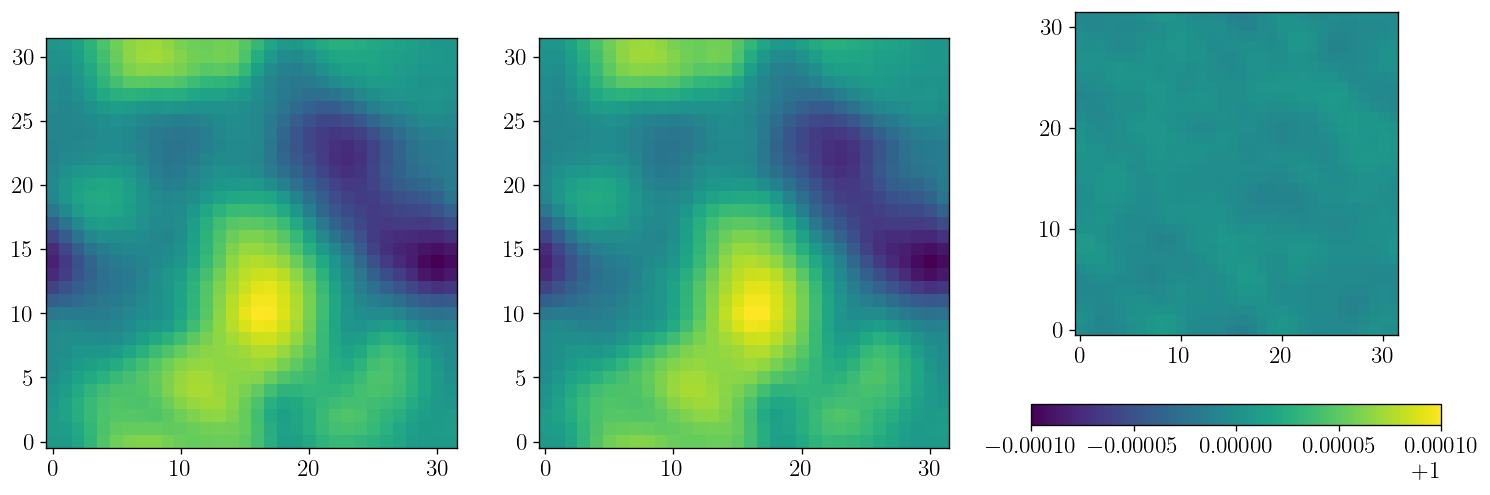

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(1+delta_1[0], origin='lower', cmap='viridis')
axs[1].imshow(1+delta_2[0], origin='lower', cmap='viridis')
im = axs[2].imshow((1+delta_2[0])/(1+delta_1[0]), origin='lower', cmap='viridis', vmin=0.9999, vmax=1.0001)
fig.colorbar(im, ax=axs[2], orientation='horizontal')

In [ ]:
# save 1+delta, dep, and x_e boxes
for i in tqdm(range(len(z_s))):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    ax = axs[0]
    im = ax.imshow(deltaplusone_box_s[i][0] / np.mean(deltaplusone_box_s[i][0]), origin='lower')
    ax.set(title=f"1+delta: z={z_s[i]:.3f} R={R_arr[i]:.3f}")
    fig.colorbar(im, ax=ax, orientation='horizontal')

    ax = axs[1]
    im = ax.imshow(dep_ion_box_s[i][0] / np.mean(dep_ion_box_s[i][0]), origin='lower')
    fig.colorbar(im, ax=ax, orientation='horizontal')
    ax.set(title='dep')

    ax = axs[2]
    im = ax.imshow(x_e_box[0], origin='lower')
    fig.colorbar(im, ax=ax, orientation='horizontal')
    ax.set(title='x_e')
    fig.savefig(f"tmp/{i}.png")
    plt.close()

100%|██████████| 39/39 [00:50<00:00,  1.31s/it]


In [ ]:
flist = []
for i in tqdm(range(len(z_s))):
    flist.append(f"tmp/{i}.png")
create_gif_from_filelist(flist, "2.gif", 0.5)

100%|██████████| 39/39 [00:00<00:00, 629145.60it/s]

In [ ]:
z4 = input_ionization.input_ionization[0]
z3 = dep_ion_box[0] / phys.rydberg # / np.mean(dep_ion_box) * ref_interp(z_current)
z2 = dxe_dc
z1 = dxe_pc
vmin = np.quantile(np.concatenate([z1, z2, z3, z4]), 0.02)
vmax = np.quantile(np.concatenate([z1, z2, z3, z4]), 0.98)

fig, axs = plt.subplots(1, 4, figsize=(24, 6))
axs[0].imshow(z1, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].imshow(z2, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
axs[2].imshow(z3, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
axs[3].imshow(z4, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
for i, title in enumerate(['run 21cmfast', 'run DM21cm', 'manual DM21cm', 'manual DM21cm code']):
    axs[i].set_title(title)
#plt.imshow(z, origin='lower', cmap='viridis')
print(np.std(z1)/np.mean(z1), np.mean(z1))
print(np.std(z2)/np.mean(z2), np.mean(z2))
print(np.std(z3)/np.mean(z3), np.mean(z3))
print(np.std(z4)/np.mean(z4), np.mean(z4))

In [ ]:
rn_s_pc = [
    'sf_xdecayx10_nodplus1_noxesink_nopop2_alldepion_zf001',
]

r_s_dc = [get_rec(rn) for rn in rn_s_dc]
r_s_pc = [get_rec(rn) for rn in rn_s_pc]

ax = axs[0]
for rec in r_s_dc:
    ax.plot(*shell_dc(rec, i, dlogR=False), '-s', label=r'DM21cm $\sim\times1$', alpha=0.5)
for rec in r_s_pc:
    ax.plot(*shell_pc(rec, i, dlogR=False), '-*', label=r'21cmFAST $\sim\times1/R$')
ax.set(xlabel=r'$R$ [Mpc]', ylabel=r'$\epsilon/dR$ [eV/B/Mpc]')
ax.legend()

ax = axs[1]
for rec in r_s_dc:
    ax.plot(*shell_dc(rec, i, dlogR=True), '-s', label=r'DM21cm $\sim\times R$')
for rec in r_s_pc:
    ax.plot(*shell_pc(rec, i, dlogR=True), '-*', label=r'21cmFAST $\sim\times1$')
ax.set(xscale='log')
ax.set(xlabel=r'$R$ [Mpc]', ylabel=r'$\epsilon/d\log_{10}R$ [eV/B/Mpc]')
ax.legend()

In [ ]:
rec['p']

array([{'dep_ion_bath': 0.0, 'dep_heat_bath': 0.0, 'dep_ion_shells': array([], dtype=float64), 'dep_heat_shells': array([], dtype=float64), 'R_shells': array([], dtype=float64), 'bath_toteng_arr': []},
       {'dep_ion_bath': 0.0, 'dep_heat_bath': 0.0, 'dep_ion_shells': array([], dtype=float64), 'dep_heat_shells': array([], dtype=float64), 'R_shells': array([], dtype=float64), 'bath_toteng_arr': []},
       {'dep_ion_bath': 0.0, 'dep_heat_bath': 0.0, 'dep_ion_shells': array([], dtype=float64), 'dep_heat_shells': array([], dtype=float64), 'R_shells': array([], dtype=float64), 'bath_toteng_arr': []},
       ...,
       {'dep_ion_bath': 0.0, 'dep_heat_bath': 0.0, 'dep_ion_shells': array([], dtype=float64), 'dep_heat_shells': array([], dtype=float64), 'R_shells': array([], dtype=float64), 'bath_toteng_arr': []},
       {'dep_ion_bath': 0.0, 'dep_heat_bath': 0.0, 'dep_ion_shells': array([], dtype=float64), 'dep_heat_shells': array([], dtype=float64), 'R_shells': array([], dtype=float64), 'b

/tmp/ipykernel_349766/4251548546.py:2: RuntimeWarning: divide by zero encountered in log10
  ax.plot(R_arr[1:], dep_ion_arr[1:]/np.diff(-np.log10(R_arr))/phys.rydberg/2, '-s')


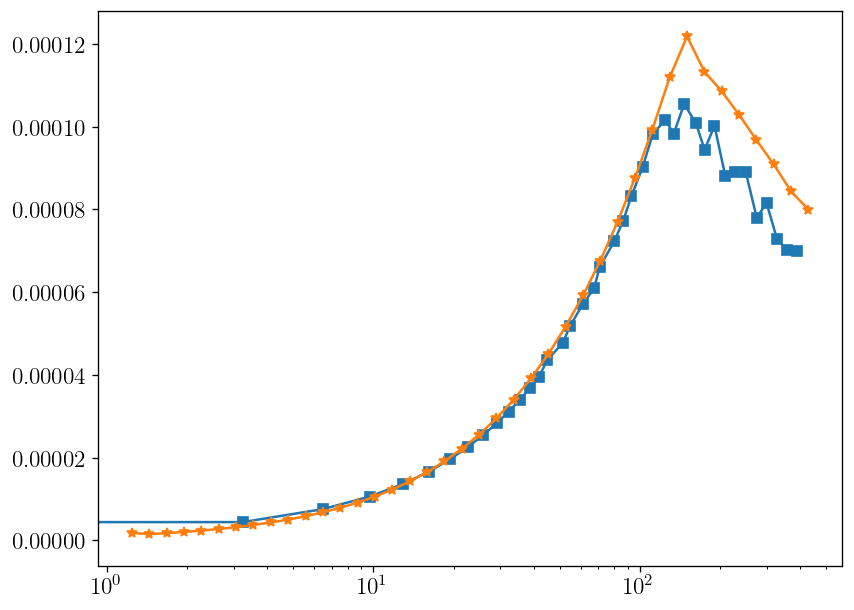

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(R_arr[1:], dep_ion_arr[1:]/np.diff(-np.log10(R_arr))/phys.rydberg/2, '-s')

rn_s_pc = [
    'sf_xdecayx10_nodplus1_noxesink_nopop2_alldepion_zf001',
]
r_s_pc = [get_rec(rn) for rn in rn_s_pc]
for rec in r_s_pc:
    r, v = shell_pc(rec, i, dlogR=True)
    ax.plot(r, v, '-*', label=r'21cmFAST $\sim\times1$')
ax.set_xscale('log')

In [ ]:
R_for_z = [phys.conformal_dx_between_z(z, 5.) for z in z_edges]
R_to_z = interpolate.interp1d(R_for_z, z_edges)

In [ ]:
total_box = np.zeros((32, 32, 32))

rec = get_rec('sf_xdecayx10_nodplus1_noxesink_nopop2_alldepion_zf001')
r_rec, n_rec = shell_pc(rec, i, dlogR=True)

for R, norm in zip(r_rec, n_rec):
    z = R_to_z(R)
    delta = delta_cacher_recon.brightness_cache.get_box(z)
    delta_smoothed, _ = delta_cacher_recon.smooth_box(delta, 1e-10, R)
    total_box += (1+delta_smoothed) * norm

0.01227664276457623 0.0016799115645112286


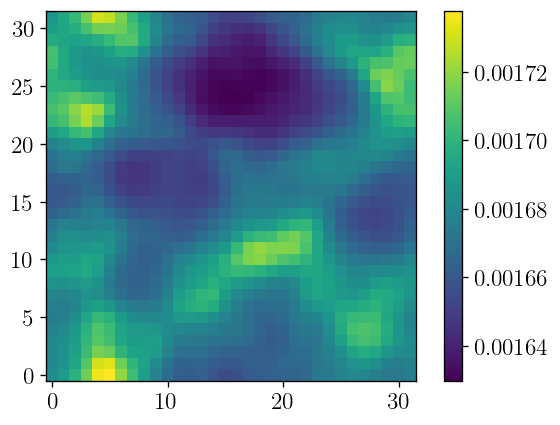

In [ ]:
plt.imshow(total_box[0], origin='lower')
plt.colorbar()

print(np.std(total_box)/np.mean(total_box), np.mean(total_box))